# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
sns.set()

# Importing the training dataset

In [3]:
train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


- 891 rows
- Age and embarked data are missing
- A significant amount of Cabin data are missing which renders it useless as a feature

In [5]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
(train.isna().sum()/train.shape[0])*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [7]:
df_train = train.copy()

# Dealing with missing values
We need to deal with missing values of - Age, Embarked and Cabin columns.

- For age, we will have to think of some imputing method to fill the values with since deleting the 177 rows will cost us too much information.
- We can afford to delete two rows where embarked column has missing values.
- We will delete the entire Cabin column since it has no use for us whatsoever

In [8]:
df_train.drop("Cabin", axis=1, inplace=True)

## Imputing method for filling missing age column
We can easily fill the missing age values with the mean of all ages present. But this will not be accurate since the range of age is pretty large (0-80 years).

Instead, we'll use a column in the current dataframe that will help us classify the age range of the person. While this information is not straightforwardly available, if we look carefully at the name column, we can see that it's written in a specific order:

Surname, Title. Name
What does the title tell us?

- Master: A young boy
- Miss: A young girl
- Mr: A man
- Mrs: A married woman
- And so on...
(Note: There is no hard and fast definition for some of these titles and as of the present time, they are used flexibly)

Thus, we can extract this title information from the name and calculate the individual mean for people with these titles and then assign this mean to the age value. This way, the error will be reduced as compared to assigning the whole dataset mean.

In [9]:
df_train["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [10]:
df_train["Title"] = df_train["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())

In [11]:
df_train["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Now we use the groupby method along with the transform method to calculate the means of the ages when grouped according the titles listed above. Using transform, we then assign this mean value to each of the missing values in Age column in the dataframe.

In [12]:
df_train['Age'] = df_train['Age'].fillna(df_train.groupby('Title')['Age'].transform('mean'))

In [13]:
df_train.dropna(subset=['Embarked'],inplace=True)

In [14]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

# Feature Extraction
In this section we will try to extract some information from the tickets column, after which we will see what we can do with the title column as well and finally end the section with indtroducing a FamilySize column to our data.

### Ticket Type

As of now, we are unsure as to what type of information we are expecting. So we will start by just exploring the ticket column and what kind of data it holds.

In [15]:
df_train.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It seems like it has a ticket number in all the tickets but in some tickets has some kind of alpha-numeric code leading the ticket number.

Let's try to extract this code.

In [16]:
#We store the aplha-numeric code in the newly created column Ticket_type. If no code exists we'll assign it a '0'
df_train["Ticket_type"] = df_train["Ticket"].apply(lambda x: x.split()[0] if len(x.split())>1 else "0")

In [17]:
df_train['Ticket_type'].unique()

array(['A/5', 'PC', 'STON/O2.', '0', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

From the above list we can see all the ticket types existing in the dataset. Observing the names of the tickets we can see that they represent a location; probably a pair of boarding and destination points but we are not sure. Later in the EDA section we'll see what information this column can give us.

Since the number of data for all these codes is not sufficient, it may not be a good idea to consider them in the current form. Instead, we will group the ticket type by using just the initials of the ticket code.

In [18]:
df_train["Ticket_type"] = df_train['Ticket_type'].apply(lambda x: x[0])

In [19]:
df_train['Ticket_type'].value_counts()

0    663
P     65
S     65
C     47
A     29
W     13
F      7
Name: Ticket_type, dtype: int64

Now we have 7 groups of ticket type but we still have less data in A, W and F types. Let's group them together and create a single type named AFW

In [20]:
df_train["Ticket_type"] = df_train['Ticket_type'].apply(lambda x: "AFW" if x in"AFW" else x)

In [21]:
df_train['Ticket_type'].value_counts()

0      663
P       65
S       65
AFW     49
C       47
Name: Ticket_type, dtype: int64

### Title

Let's work on the title column now.

From our previous imputation, we noted that there are 17 different titles. We will check how many passengers of each data type are present on the ship.

In [22]:
df_train['Title'].value_counts()

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

As we can see here the majority of the titles are 'Mr', 'Miss', 'Mrs' and 'Master'. We can obviously put the other titles in these four groups.

For that, we will use groupby using Title and Sex to identify the genders in case we are unsure of what some of the titles may mean.

In [23]:
df_train.groupby(['Title','Sex']).count()

PassengerId  Survived  Pclass  Name  Age  SibSp  Parch  \
Title        Sex                                                              
Capt         male              1         1       1     1    1      1      1   
Col          male              2         2       2     2    2      2      2   
Don          male              1         1       1     1    1      1      1   
Dr           female            1         1       1     1    1      1      1   
             male              6         6       6     6    6      6      6   
Jonkheer     male              1         1       1     1    1      1      1   
Lady         female            1         1       1     1    1      1      1   
Major        male              2         2       2     2    2      2      2   
Master       male             40        40      40    40   40     40     40   
Miss         female          181       181     181   181  181    181    181   
Mlle         female            2         2       2     2    2      2      2   
Mme          female            1         1       1     1    1      1      1   
Mr           male            517       517     517   517  517    517    517   
Mrs          female          124       124     124   124  124    124    124   
Ms           female            1         1       1     1    1      1      1   
Rev          male              6         6       6     6    6      6      6   
Sir          male              1         1       1     1    1      1      1   
the Countess female            1         1       1     1    1      1      1   

                     Ticket  Fare  Embarked  Ticket_type  
Title        Sex                                          
Capt         male         1     1         1            1  
Col          male         2     2         2            2  
Don          male         1     1         1            1  
Dr           female       1     1         1            1  
             male         6     6         6            6  
Jonkheer     male         1     1         1            1  
Lady         female       1     1         1            1  
Major        male         2     2         2            2  
Master       male        40    40        40           40  
Miss         female     181   181       181          181  
Mlle         female       2     2         2            2  
Mme          female       1     1         1            1  
Mr           male       517   517       517          517  
Mrs          female     124   124       124          124  
Ms           female       1     1         1            1  
Rev          male         6     6         6            6  
Sir          male         1     1         1            1  
the Countess female       1     1         1            1

Now we create a dictionary to map the titles to just four of them. All the titles except doctor have a single gender.

For the title 'Dr', we have 1 female and 6 males. Since we will have to assign a single title, we'll go with the most frequent strategy and assign it 'Mr'

In [24]:
# We will use the fromkeys method of dictionaries to create one with 'Mr' assigned as the default value.
# Later we'll change the values accordingly
title_dict = dict.fromkeys(df_train["Title"].unique(),"Mr")
title_dict

{'Mr': 'Mr',
 'Mrs': 'Mr',
 'Miss': 'Mr',
 'Master': 'Mr',
 'Don': 'Mr',
 'Rev': 'Mr',
 'Dr': 'Mr',
 'Mme': 'Mr',
 'Ms': 'Mr',
 'Major': 'Mr',
 'Lady': 'Mr',
 'Sir': 'Mr',
 'Mlle': 'Mr',
 'Col': 'Mr',
 'Capt': 'Mr',
 'the Countess': 'Mr',
 'Jonkheer': 'Mr'}

In [25]:
# Using update method of dictionary to update some of the keys that don't have the value 'Mr'
title_dict.update([('Mrs','Mrs'),('Miss','Miss'),('Master','Master'),('Mme','Mrs'),('Ms','Miss'),('Lady','Mrs'),
                   ('Mlle','Mrs'),('the Countess','Mrs')])

In [26]:
df_train['Title'] = df_train['Title'].map(title_dict)

In [27]:
df_train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

### Family Size

Let's end this section by adding a family size column to the data.

We have two columns named SibSp and Parch to quantify the number of Siblings/Spouse and Parents/Children one has on the ship with them.

If we add these two numbers we will get the number of family members one has aboard the ship. This information is more relevant than having two separate columns of different family member types. Another thing to note here, all the members of the same family will have the same number of family members in this column, this makes it easy to cluster them as one family.

In [28]:
# Add the number of members and drop the two columns

df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_train.drop(['SibSp','Parch'],axis=1,inplace=True)

In [29]:
df_train['FamilySize'].unique()

array([ 1,  0,  4,  2,  6,  5,  3,  7, 10])

We have passengers with as many as 10 family members with them on the ship. Let's get rid of the numbers and create bins to group them.

0 - Alone\ 1 to 3 - Small\ 4 - 6 - Medium\ 7 and more - Large

In [30]:
# We will use the pandas cut method to create bins for different family size intervals

df_train['FamilySize'] = pd.cut(df_train['FamilySize'],bins=[0,1,4,7,100],labels=['Alone','Small','Medium','Large'],right=False)


In [31]:
df_train['FamilySize'].unique()

['Small', 'Alone', 'Medium', 'Large']
Categories (4, object): ['Alone' < 'Small' < 'Medium' < 'Large']

So finally we have four family size groups. We will make use of this to visualize some nuances of the survival based on family size in our EDA section ahead.

### Cleaning rest of the data

We have no use of - PassengerId, Name, Ticket, Title columns anymore since we have already made use of it. So we will delete them now

In [32]:
df_train.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)

#Resetting the index since we deleted a few rows earlier
df_train.reset_index(drop=True,inplace=True)

df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Ticket_type,FamilySize
0,0,3,male,22.0,7.2500,S,Mr,AFW,Small
1,1,1,female,38.0,71.2833,C,Mrs,P,Small
2,1,3,female,26.0,7.9250,S,Miss,S,Alone
3,1,1,female,35.0,53.1000,S,Mrs,0,Small
4,0,3,male,35.0,8.0500,S,Mr,0,Alone


# EDA
We shall now explore the relationships between the features and the survival of the passengers in the titanic using some seaborn visualizations.

Let's start with visualizing what the distributions of our numerical features - Age and Fare - look like

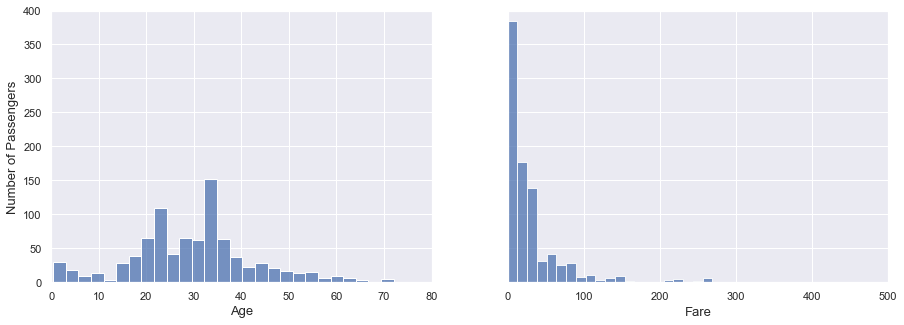

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5),sharey=True)

sns.histplot(df_train['Age'],bins=30,ax=ax1)
ax1.set_xlim([0,80])
ax1.set_ylim([0,400])
ax1.set_xlabel('Age',fontdict={'fontsize':13})
ax1.set_ylabel('Number of Passengers',fontdict={'fontsize':13})

sns.histplot(df_train['Fare'],ax=ax2,bins=40)
ax2.set_xlim([0,500])
ax2.set_xlabel('Fare',fontdict={'fontsize':13})

plt.show()

**Observations**:

From the age distribution, we see the age concentrated around 30 years and a smaller distribution below 10 years indicating all the child population.
From the fare distribution, we see that most of the people paid less than 100 bucks.
We will now dwelve into deeper visualizations based on Age, Sex, Title, Fare, Passenger class and Family Size.

Let's begin the analysis with survival based on gender.

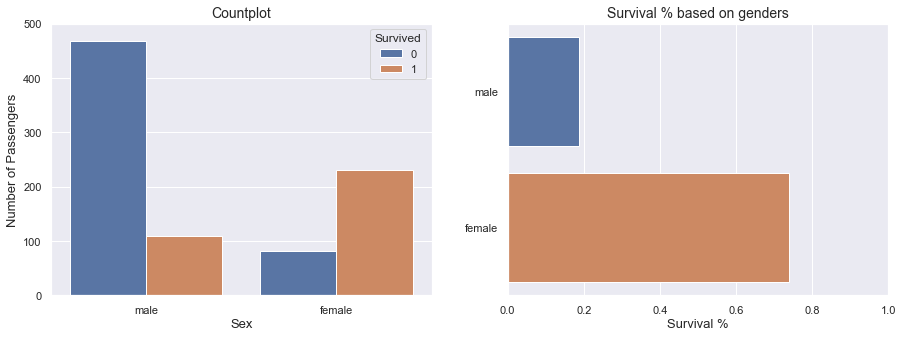

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='Sex',data=df_train,hue='Survived',ax=ax1)
ax1.set_ylim([0,500])
ax1.set_xlabel('Sex',fontdict={'fontsize':13})
ax1.set_ylabel('Number of Passengers',fontdict={'fontsize':13})
ax1.set_title('Countplot',fontdict={'fontsize':14})

sns.barplot(x='Survived',y='Sex',data=df_train,errwidth=0,ax=ax2)
ax2.set_xlim([0,1])
ax2.set_xlabel('Survival %',fontdict={'fontsize':13})
ax2.set_ylabel('',fontdict={'fontsize':13})
ax2.set_title('Survival % based on genders',fontdict={'fontsize':14})

plt.show()

**Observation**: Clearly, more % of females survived than the males did since more priority must have been given to the women and children.

**Conclusion 1**: Sex is an important feature to consider since gender is clearly influencing the chances of survival.

Now let's explore relationships between age and the title that we extracted in the feature extraction section

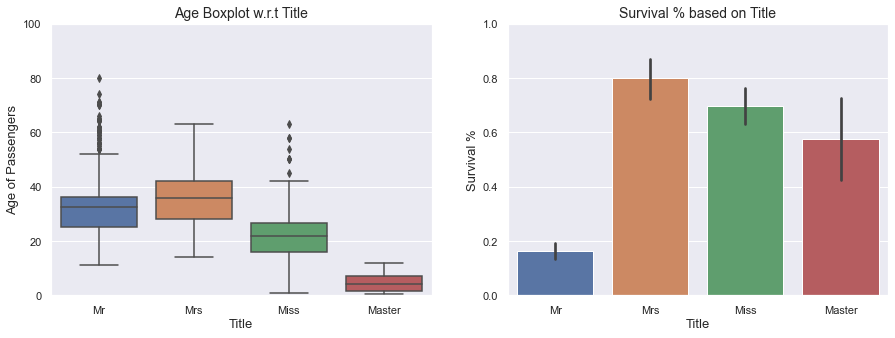

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

sns.boxplot(x='Title',y='Age',data=df_train,ax=ax1)
ax1.set_ylim([0,100])
ax1.set_xlabel('Title',fontdict={'fontsize':13})
ax1.set_ylabel('Age of Passengers',fontdict={'fontsize':13})
ax1.set_title('Age Boxplot w.r.t Title',fontdict={'fontsize':14})

sns.barplot(x='Title',y='Survived',data=df_train,ax=ax2)
ax2.set_ylim([0,1])
ax2.set_xlabel('Title',fontdict={'fontsize':13})
ax2.set_ylabel('Survival %',fontdict={'fontsize':13})
ax2.set_title('Survival % based on Title',fontdict={'fontsize':14})

plt.show()

**Observations**:

- From the age boxplot, we see that how Mr and Mrs have higher median age while Miss has lower and Master has an even lower meadian age. This is precisely why we used the titles to impute the mean age of passengers since it explains the age to some extent.
- From the survival rates, we can observe that women (Mrs and Miss) and children (Miss and Master) have the highest survival rates as compared to adult men (Mr). This is obvious because the Title completely explains the gender of the passenger whose relation with survival we already know.

**Conclusion 2**: Title feature can be dropped from our data since the information it gives is already explained by Age and Sex combined.

In [36]:
df_train.drop('Title',axis=1,inplace=True)

In [37]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Ticket_type,FamilySize
0,0,3,male,22.0,7.2500,S,AFW,Small
1,1,1,female,38.0,71.2833,C,P,Small
2,1,3,female,26.0,7.9250,S,S,Alone
3,1,1,female,35.0,53.1000,S,0,Small
4,0,3,male,35.0,8.0500,S,0,Alone


Now we will explore the relationships between Fare and Passenger Class

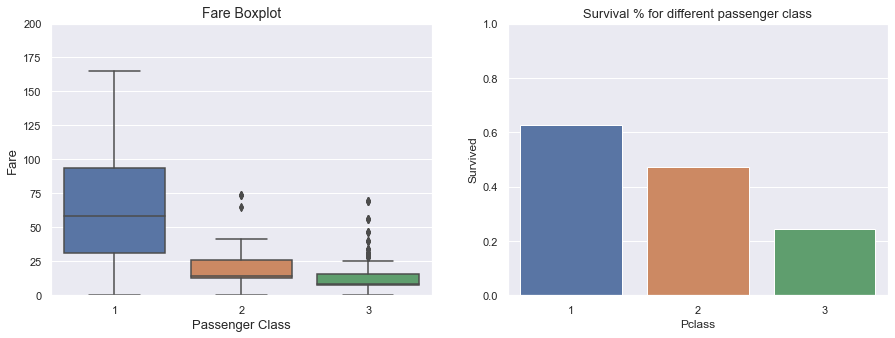

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharex=True)

sns.boxplot(x='Pclass',y='Fare',data=df_train,ax=ax1)
ax1.set_ylim([0,200])
ax1.set_xlabel('Passenger Class',fontdict={'fontsize':13})
ax1.set_ylabel('Fare',fontdict={'fontsize':13})
ax1.set_title('Fare Boxplot',fontdict={'fontsize':14})

sns.barplot(x='Pclass',y='Survived',data=df_train,errwidth=0,ax=ax2)
ax2.set_ylim([0,1])
ax2.set_title('Survival % for different passenger class',fontdict={'fontsize':13})

plt.show()

**Observations**:

- The higher (numerically lower) the passenger class, the higher is the fare.
- Passengers in higher (numerically lower) class have higher likelihood of survival.

**Conclusion 3**: Passenger Class is another important feature we need to keep in our model since it influences chances of survival.

Now we will see if we find any relationship between survival and the ticket type we extracted from our data.

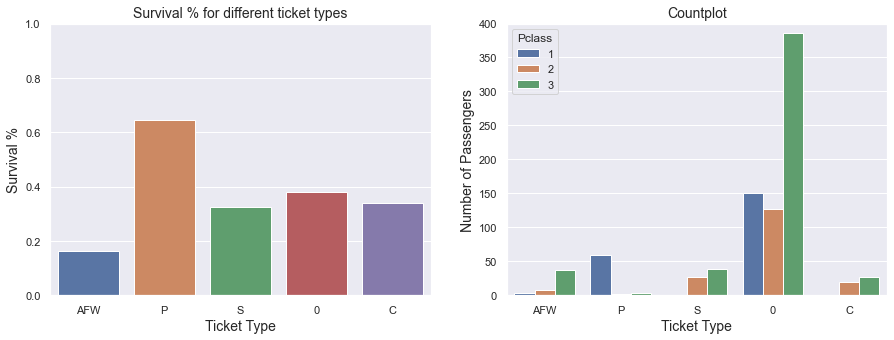

In [39]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

sns.barplot(x='Ticket_type',y='Survived',data=df_train,errwidth=0,ax=ax1)
ax1.set_title('Survival % for different ticket types',fontdict={'fontsize':14})
ax1.set_ylim([0,1])
ax1.set_xlabel('Ticket Type',fontdict={'fontsize':14})
ax1.set_ylabel('Survival %',fontdict={'fontsize':14})


sns.countplot(x='Ticket_type',data=df_train,hue='Pclass',ax=ax2)
ax2.set_title('Countplot',fontdict={'fontsize':14})
ax2.set_ylim([0,400])
ax2.set_xlabel('Ticket Type',fontdict={'fontsize':14})
ax2.set_ylabel('Number of Passengers',fontdict={'fontsize':14})

plt.show()

**Observations:**

1. We see a low survival rate for ticket type AFW while a very high one for ticket type P. Rest are somewhat similar.
2. From the countplot, we can see why is this so. Ticket type AFW has most of the passengers in the Pclass 3 while ticket type P has most of the passengers in Pclass 1 which we already know has a higher rate of survival. This reflects in our ticket type survival rate as well.
3. For the types S and C, we have similar number of passengers in Pcalss 2 and 3 but very less or none in Pclass 1.
4. For type 0, most of the passengers are in PClass 3 but it still has higher survival rate than S or C. This is beacause type 0 also has significant amount of passengers in PClass 1 and 2 as well.

**Conclusion 4:** We can safely say that Ticket Type is an important feature for our model since Pclass alone cannot completely explain the survival. That is to say, a passenger in PClass 1 with ticket type P has higher chances of survival than the one with Ticket Type AFW. As we can see, we also need the additional information about the ticket type to correctly identify the survival rate and not just base it on Pclass.

We will end this EDA section with analysis of the FamilySize feature we extracted and see how the size affects the survival.

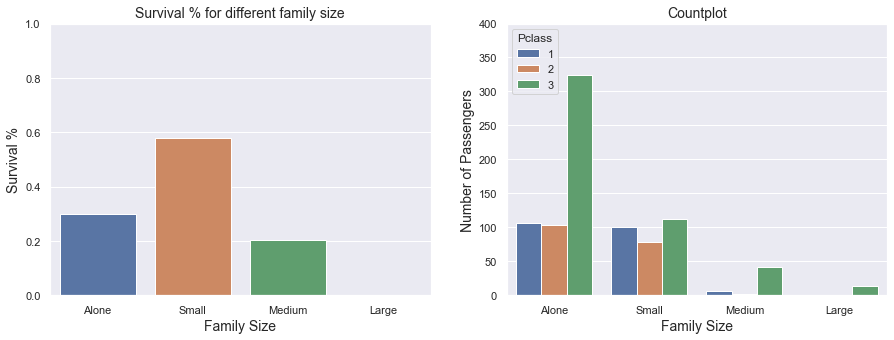

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

sns.barplot(x='FamilySize',y='Survived',data=df_train,errwidth=0,ax=ax1)
ax1.set_title('Survival % for different family size',fontdict={'fontsize':14})
ax1.set_ylim([0,1])
ax1.set_xlabel('Family Size',fontdict={'fontsize':14})
ax1.set_ylabel('Survival %',fontdict={'fontsize':14})


sns.countplot(x='FamilySize',data=df_train,hue='Pclass',ax=ax2)
ax2.set_title('Countplot',fontdict={'fontsize':14})
ax2.set_ylim([0,400])
ax2.set_xlabel('Family Size',fontdict={'fontsize':14})
ax2.set_ylabel('Number of Passengers',fontdict={'fontsize':14})

plt.show()

**Observations:**
​
1. People who were with small families (1-3 members) had the highest survival rate.
2. The larger the family, the lesser the chances to survive.
3. Being alone has lesser chances of survival than being with a small family but higher then medium and large families.
4. The passengers who were onboard with small families had similar number of people in all passenger classes. 
5. All other passengers had higher % of people in the PClass 3.
​
**Conclusion 5:** Our grouping of family size has made it very simple to visualize the relationship between family size and survival. Since it explains the survival, we will keep it in our model.

# Data Cleaning and Feature Extraction for Test data¶
This will be done in the exact same fashion for the test.csv as we did it for train.csv and won't be explained.

In [41]:
test = pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [42]:
df_test = test.copy()

#Extracting title information

df_test['Title'] = df_test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [43]:
# Imputing missing Age values

df_test['Age'] = df_test['Age'].fillna(df_test.groupby('Title')['Age'].transform('mean'))

In [44]:
# Extracting ticket type information

df_test['Ticket_type'] = df_test['Ticket'].apply(lambda x: x.split()[0] if len(x.split())>1 else '0')
df_test['Ticket_type'] = df_test['Ticket_type'].apply(lambda x: x[0])
df_test['Ticket_type'] = df_test['Ticket_type'].apply(lambda x: 'AFW' if x in 'AFW' else x)

In [45]:
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_type
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,0


In [46]:
df_test.fillna(df_test.groupby('Pclass')['Fare'].mean()[3],inplace=True)

In [47]:
# Extracting family size information and dropping SibSp and Parch columns

df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']
df_test.drop(['SibSp','Parch'],axis=1,inplace=True)
df_test['FamilySize'] = pd.cut(df_test['FamilySize'],bins=[0,1,4,7,100],labels=['Alone','Small','Medium','Large'],right=False)

In [48]:
df_test.drop(['PassengerId','Name','Ticket','Cabin','Title'],axis=1,inplace=True)
df_test.reset_index(drop=True,inplace=True)
df_test.head()

,Pclass,Sex,Age,Fare,Embarked,Ticket_type,FamilySize
0,3,male,34.5,7.8292,Q,0,Alone
1,3,female,47.0,7.0000,S,0,Small
2,2,male,62.0,9.6875,Q,0,Alone
3,3,male,27.0,8.6625,S,0,Alone
4,3,female,22.0,12.2875,S,0,Small


# Data Preprocessing
In this section, we will encode categorical variables and standardize the numerical ones to prepare for our ML models.

Since each model takes different kinds of inputs, we will create the training sets accordingly.

**Logistic Regression** - Standardization not necessary (sklearn implementation takes care of it)\
**K Nearest Neighbors** - Data standardized\
**Support Vector Machines** - Data standardized\
**Decision Tree and Random Forest** - Standardization not necessary

Thus, we'll create two sets of inputs and targets based on the above model requirements

In [49]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Ticket_type,FamilySize
0,0,3,male,22.0,7.2500,S,AFW,Small
1,1,1,female,38.0,71.2833,C,P,Small
2,1,3,female,26.0,7.9250,S,S,Alone
3,1,1,female,35.0,53.1000,S,0,Small
4,0,3,male,35.0,8.0500,S,0,Alone


In [50]:
y_train = df_train['Survived']
x_train = df_train.drop(['Survived'],axis=1)

## One Hot Encoding
We'll create an object of the class ColumnTransformer to One Hot Encode our categorical variables




In [51]:
clt = ColumnTransformer([('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'),[1,4,5,6])],
                        remainder='passthrough',verbose_feature_names_out=False)

**Note**: Even though for Logistic Regression we are supposed to drop one category from the encoded feature to avoid multicollinearity, the sklearn implementation takes care of it even if we don't drop the variable. So we'll skip that step here.

In [52]:
x_train = clt.fit_transform(x_train)

In [53]:
x_train = pd.DataFrame(x_train,columns=clt.get_feature_names_out())
x_train.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Ticket_type_0,Ticket_type_AFW,Ticket_type_C,Ticket_type_P,Ticket_type_S,FamilySize_Alone,FamilySize_Large,FamilySize_Medium,FamilySize_Small,Pclass,Age,Fare
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,22.0,7.2500
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,38.0,71.2833
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,26.0,7.9250
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,35.0,53.1000
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,35.0,8.0500


We finally have a One Hot Encoded training set. We'll repeat similar steps for the test data as well.

**Note**: Pclass column has data that has data type as int64. Even then, it is a categorical variable. We call such a category to be of the ordinal category.

In [54]:
x_test = clt.transform(df_test)
x_test = pd.DataFrame(x_test,columns=clt.get_feature_names_out())

## Standardizing
Here we standardize the numerical variables of our data - Pclass, Age, Fare

In [55]:
# Saving the list of numerical and categorical names for ease of use

num_col = ['Pclass', 'Age', 'Fare']

cat_col = ['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
                'Ticket_type_0', 'Ticket_type_AFW', 'Ticket_type_C',
                'Ticket_type_P', 'Ticket_type_S', 'FamilySize_Alone',
                'FamilySize_Large', 'FamilySize_Medium', 'FamilySize_Small'] 

In [56]:
# Creating a standard scalar object and fitting the training data

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[num_col])

# Creating a dataframe for ease of viewing

x_train_scaled = pd.DataFrame(x_train_scaled,columns=num_col)
x_train_scaled = pd.concat([x_train[cat_col],x_train_scaled],axis=1)
x_train_scaled.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Ticket_type_0,Ticket_type_AFW,Ticket_type_C,Ticket_type_P,Ticket_type_S,FamilySize_Alone,FamilySize_Large,FamilySize_Medium,FamilySize_Small,Pclass,Age,Fare
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.825209,-0.582365,-0.500240
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.572211,0.626314,0.788947
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.825209,-0.280196,-0.486650
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.572211,0.399687,0.422861
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.825209,0.399687,-0.484133


In [57]:
x_test_scaled = scaler.transform(x_test[num_col])
x_test_scaled = pd.DataFrame(x_test_scaled,columns=num_col)
x_test_scaled = pd.concat([x_test[cat_col],x_test_scaled],axis=1)

# ML Prediction

We start off our prediction section with cross validation scores to reduce the number of models we will be working on.

## Cross Validation
Cross-validation is a technique which tells how our model will behave with different splits of training and testing data. This is important to remove any bias introduced by the randomness of training and testing data selection. For k-splits, we get k number of scores and we can decide if we want them separately or combine them with an aggregate function.

For our use, we will use the mean of the 10-fold CV scores.


First we create two lists of models. Two since we have two different training sets for our concerned models.

In [58]:
model_list_1 = [LogisticRegression(),KNeighborsClassifier(),SVC()]
model_list_2 = [DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42)]

Now we define a function which can quickly give us the results in a single array so that we don't have to run each CV again and again.

In [59]:
def getCVscore(l1,l2):
    res = []
    
    # Running a CV score loop for the first set of models - Training data scaled
    for model in l1:
        res.append(cross_val_score(model,x_train_scaled,y_train,cv=10,scoring='accuracy').mean())
    
    # Running a CV score loop for the second set of models - Training data not scaled
    for model in l2:
        res.append(cross_val_score(model,x_train,y_train,cv=10,scoring='accuracy').mean())
    
    return res

In [60]:
getCVscore(model_list_1,model_list_2)

[0.8132916241062308,
 0.8031537282941776,
 0.8279239019407558,
 0.7750638406537282,
 0.8065628192032687]

As we can see from above, with no parameters passed the best performing model is the Support Vector Classifier. If we rank them based on our CV score:

1. SVC
2. Logistic Regression
3. Random Forest
4. KNN
5. Decision Tree

## Grid Search CV for Hyperparameter Tuning

We will use scikit-learn's GridSearchCV to tune our hyperparameters for our final selected models and make predictions on the test data.

### SVC

In [61]:
# Creating a GridSearchCV object for tuning parameters for SVC model

params = {'C':[0.1,0.5,1,10,100],'kernel':['linear','poly','rbf','sigmoid'],'gamma':[1e-3,1e-4,1e-2,1e-1]}
gs = GridSearchCV(estimator=SVC(),param_grid=params,verbose=1)

In [62]:
# Fitting the training data

gs.fit(x_train_scaled,y_train)
gs.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [63]:
# Fitting the training data with the tuned parameters

svc = SVC(C=100,gamma=0.01)
svc.fit(x_train_scaled,y_train)

# Storing the predictions for the test data
pred_svc = svc.predict(x_test_scaled)

### Decision Tree Classifier

In [64]:
params = {'criterion':['gini','entropy'],'max_depth':np.array(range(1,11)),
          'min_samples_leaf':np.array(range(1,11))}

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_grid=params,verbose=1)


In [65]:
# Fitting the training data

gs.fit(x_train,y_train)
gs.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3}

In [66]:
# Fitting the training data with the tuned parameters

dtree = DecisionTreeClassifier(max_depth=7,min_samples_leaf=3,random_state=42)
dtree.fit(x_train,y_train)

# Storing the predictions for the test data
pred_dtree = dtree.predict(x_test)

### Random Forest Classifier

In [67]:
# Creating a GridSearchCV object for tuning parameters for Random Forest model

params = {'n_estimators':[100,200,300,400,500,600]}

gs = GridSearchCV(estimator=RandomForestClassifier(max_depth=7,min_samples_leaf=3,random_state=42),param_grid=params,verbose=1)

In [68]:
gs.fit(x_train,y_train)
gs.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'n_estimators': 300}

In [69]:
# Fitting the training data with the tuned parameters

rfc = RandomForestClassifier(300,max_depth=7,min_samples_leaf=3,random_state=42)
rfc.fit(x_train,y_train)

# Storing the predictions for the test data
pred_rfc = rfc.predict(x_test)

### Confusion Matrix Study for Training Set Fitting

Here, we will just check how well our model has fitted on the training set using a confusion matrix.

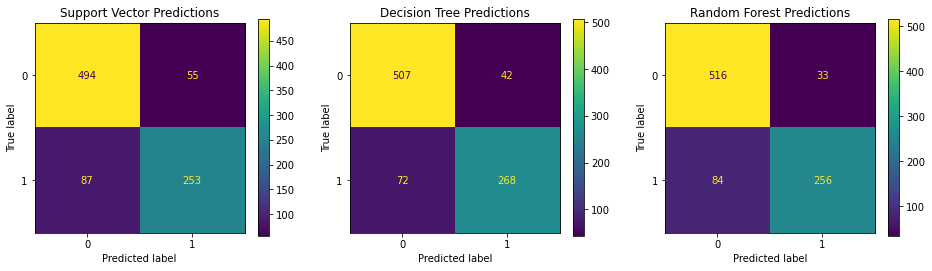

In [70]:
sns.reset_orig()
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

ConfusionMatrixDisplay.from_predictions(y_train,svc.predict(x_train_scaled),
                                        ax=ax1)
ax1.set_title('Support Vector Predictions')

ConfusionMatrixDisplay.from_predictions(y_train,dtree.predict(x_train),
                                        ax=ax2)
ax2.set_title('Decision Tree Predictions')

ConfusionMatrixDisplay.from_predictions(y_train,rfc.predict(x_train),
                                        ax=ax3)
ax3.set_title('Random Forest Predictions')

plt.show()

While this has nothing to do with how well our model will predict the test data, one thing we can observe from the above confusion matrices of training data is that our model predicts the likelihood of death (0) much better than it can predict survival (1).

This is because our dataset is imbalanced ~ 62% deaths and 38% alive

One way to imporve the predictions of survival (1) is to resample the data and balance it. It may lead to a lower accuracy but the recall and precision will surely increase for the survival (1) label.

# Submission file for Kaggle

After submitting the three prediction files, I got the best score with Random Forest Classifier. Here are the other scores:
1. Random Forest Classifier - 0.7942
2. Support Vector Classifier - 0.7894
3. Decision Tree Classifier - 0.7225

In [71]:
# Creating a new dataframe with just two columns - PassengerId and Survived (the predicted values)

submission_2 = pd.DataFrame(data=test['PassengerId'],columns=['PassengerId'])
submission_2['Survived'] = pred_rfc

In [72]:
submission_2.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [73]:
submission_2.to_csv('submission_2.csv',index=False)